For more information, please visit our project website: https://tinkerbellkr.wixsite.com/mmmfinalproject

# Simulations of the Primary Market (Initial Auctions)

## Mechanism I: With A Uniform Clearing Price (determined as the lowest winning bid, as in the current real-life auction)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats

na = 40000 # number of allowances distributed for each round; the number decreases by x annually (in this version, 90%)
x = 0.9
'''
There are two types of agents in the allowance auctions: 
1) Companies who need the allowances for their emission of carbon dioxide
2) Traders who bid to trade in the secondary market with an expectation to make a profit through the spread
'''
n_companies = 162
n_traders = 18 
reserve_price = 3 # minimum bid set by the auctioneer

'''
`companies` and `traders` define the bidding functions for the two types of agents, respectively.
Some input arguments include the size, wealth, and allowances needed for each company. 
We found some empirical studies on the distribution of those input variables and used them as the baseline to randomly generate characteristics of our agents.
'''
def companies(i, wealth, req_allowance):
    if req_allowance <= 0:
        bid = 0
        bid_vol = 0
    elif wealth <= 0:
        bid = 0
        bid_vol = 0
    else:
        value = wealth/req_allowance 
        if value > reserve_price:
            bid = value
            bid_vol = int(req_allowance)  
        else: 
            bid = reserve_price
            bid_vol = int(req_allowance)         
    return i, wealth, bid, bid_vol
    
def traders(i, wealth):
    value = reserve_price + np.random.normal(0, 3)
    if wealth <= 0:
        bid = 0
        bid_vol = 0
    elif value > reserve_price:
        bid = value
        bid_vol = int(wealth/bid)
    else:
        bid = reserve_price
        bid_vol = int(wealth/bid)
    return i, wealth, bid, bid_vol

## Initiation - First Auction
'''
An empirical study shows that the firm size distribution (of the service sector and manufacturing sector) 
follows a gamma distribution with shape of 1 and scale of 66.67. We used the result from the article to generate our agents from the same distribution.

https://www.emeraldinsight.com/doi/pdfplus/10.1108/APJIE-12-2016-011
'''
shape = 1 
scale = 66.67

participants = []
bids = []
budget = []
bid_vols = []
req_allowances = []
initial_wealth = []
initial_allowance_req = []
for i in range(n_companies):
    wealth = 230*float(np.random.gamma(shape,scale,1)) # 230 is the mean spending observed in the real auctions, thus being used as the baseline
    req_allowance = int(abs((wealth/2)*(np.random.normal(0,1))))
    num, wealth, bid, bid_vol = companies(i, wealth, req_allowance)   
    participants.append(num)
    budget.append(wealth)
    bids.append(bid)
    bid_vols.append(bid_vol)
    req_allowances.append(req_allowance)
    # FOR INITIAL WEALTH & ALLOWANCE REQUIREMENT RECORDING PURPOSES
    initial_wealth.append(wealth)
    initial_allowance_req.append(req_allowance)
    
for i in range(n_traders):
    wealth = 230*float(np.random.gamma(shape,scale,1))
    num, wealth, bid, bid_vol = traders(i,wealth)
    participants.append(num)
    budget.append(wealth)
    bids.append(bid)
    bid_vols.append(bid_vol)
    # FOR INITIAL WEALTH RECORDING PURPOSES
    initial_wealth.append(wealth)


winners = []
traders_allowances = [0]*n_traders

'''
Determine the Winning Bidders and Clearing Price

Start from the highest bidding agent, the allowances remaining decrease by the bidding volume of that particular bidders 
until the allowances run out, i.e. remaining allowances are less than the bidding volumes of the lowest winning bidder.

Every winner pays a uniform clearing price that is determined by the bidding value of the last winner aka. the lowest winning bid.
'''
winner_ind = np.flip(np.argsort(bids),0) # output the winners' indices who bid the highest to lowest
allowances_remain = na
for i in winner_ind:
    if allowances_remain < bid_vols[i]:
        break
    allowances_remain -= bid_vols[i]
    winners.append(i)
    price = bids[i]

for i in winners:
    budget[i] -= price*bid_vols[i]
    if i  <= (n_companies - 1):
        req_allowances[i] -= bid_vols[i]
    else:
        traders_allowances[i- n_companies] += bid_vols[i]

## Rest of the Auctions
Q = 24 # number of quarters (we model the auctions running for 6 years)
N = 10 # rounds of auctions per quarter
price_list = []
leftover_list = []

for k in range(Q):
    for j in range(N):    
        remaining_allowances = na
        bids = []
        bid_vols = []
        winners = []
        for i in range(n_companies+n_traders):
            if i <= (n_companies - 1): # traders start from index n_companies -1 (e.g. 162 - 1 = 161) since index starts at 0
                num, wealth, bid, bid_vol = companies(i, budget[i], req_allowances[i]) # bidding values generated from the bid functions
                bids.append(bid)
                bid_vols.append(bid_vol)
            else: 
                num, wealth, bid, bid_vol = traders(i, budget[i]) # bidding values generated from the bid functions
                bids.append(bid)
                bid_vols.append(bid_vol)

        winner_ind = np.flip(np.argsort(bids),0) # output the winners' indices who bid the highest to lowest
        for i in winner_ind:
            if remaining_allowances < bid_vols[i]:
                leftover = remaining_allowances
                break
            remaining_allowances -= bid_vols[i]
            winners.append(i)
            price = bids[i]

        price_list.append(price)
        leftover_list.append(leftover)

        for i in winners:
            budget[i] -= price*bid_vols[i]
            if i  <= (n_companies - 1):
                req_allowances[i] -= bid_vols[i]
            else:
                traders_allowances[i-n_companies] += bid_vols[i]      

'''
To mimic the real-life situation, the amount of allowances distributed decreases every year.
For each agent (both compnies and traders), the budget replenishes every quarter.
For each company, the amount of allowances needed also increases by a small factor every quarter.  
'''                
    if k % 4 == 0:
        na = int(na*x)
    for i in range(n_companies):
        budget[i] += abs(initial_wealth[i]*np.random.normal()) # budget replenishes
        req_allowances[i] += abs(int((initial_allowance_req[i])*np.random.normal())) # increased allowance demand
    for i in range(n_traders):
        budget[n_companies+i] += abs(initial_wealth[n_companies+i]*np.random.normal()) # budget replenishes
     

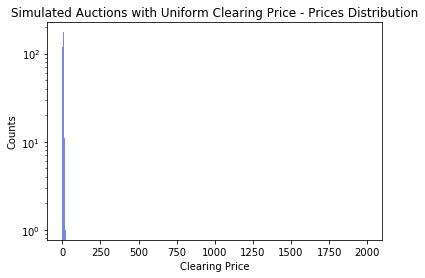

In [5]:
X = list(np.arange(0,2000,5))
plt.hist(price_list,bins=X,range=(min(X),max(X)),label=X,log=True,color='#7789E4')
plt.title('Simulated Auctions with Uniform Clearing Price - Prices Distribution')
plt.ylabel('Counts')
plt.xlabel('Clearing Price')
plt.show()

This scale was chosen for easier comparison with our results for an alternative auction mechanism (see below). 

In an auction where there is a uniform clearing price, the prices are mostly centered around 4 to 6, with relatively small variations, given the above input values. (For simulation results with different input values, see the table posted in our project website)

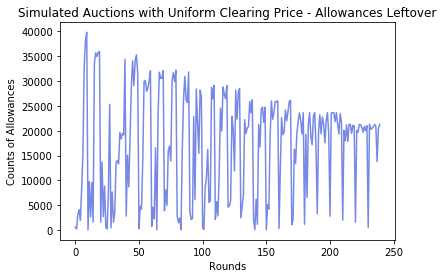

In [6]:
plt.plot(leftover_list,color='#7789E4')
plt.title('Simulated Auctions with Uniform Clearing Price - Allowances Leftover')
plt.ylabel('Counts of Allowances')
plt.xlabel('Rounds')

plt.show()

## Mechanism II: Second Price Auctions

Everything else equal, every winning agent no longer pays a uniform clearing price. Instead, each winner pays the amount of the next lower bid, as in a second price auction. 

In [26]:
na = 40000 # number of allowances distributed for each round
n_companies = 162
n_traders = 18
reserve_price = 3

def companies(i, wealth, req_allowance):
    # Bid function 
    if req_allowance <= 0:
        bid = 0
        bid_vol = 0
    elif wealth <= 0:
        bid = 0
        bid_vol = 0
    else:
        value = wealth/req_allowance 
        if value > reserve_price:
            bid = value
            bid_vol = int(req_allowance)  
        else: 
            bid = reserve_price
            bid_vol = int(req_allowance)         
    return i, wealth, bid, bid_vol
    
def traders(i, wealth):
    # Bid function
    value = reserve_price + np.random.normal(0, 3)
    if wealth <= 0:
        bid = 0
        bid_vol = 0
    elif value > reserve_price:
        bid = value
        bid_vol = int(wealth/bid)
    else:
        bid = reserve_price
        bid_vol = int(wealth/bid)
    return i, wealth, bid, bid_vol

## Initiation - First Auction
shape = 1
scale = 66.67

participants = []
bids = []
budget = []
bid_vols = []
req_allowances = []
initial_wealth = []
initial_allowance_req = []
for i in range(n_companies):
    wealth = 230*float(np.random.gamma(shape,scale,1))
    req_allowance = int(abs((wealth/2)*(np.random.normal(0,1))))
    num, wealth, bid, bid_vol = companies(i, wealth, req_allowance)   
    participants.append(num)
    budget.append(wealth)
    bids.append(bid)
    bid_vols.append(bid_vol)
    req_allowances.append(req_allowance)
    # FOR INITIAL WEALTH & ALLOWANCE REQUIREMENT RECORDING PURPOSES
    initial_wealth.append(wealth)
    initial_allowance_req.append(req_allowance)
    
for i in range(n_traders):
    wealth = 230*float(np.random.gamma(shape,scale,1))
    num, wealth, bid, bid_vol = traders(i,wealth)
    participants.append(num)
    budget.append(wealth)
    bids.append(bid)
    bid_vols.append(bid_vol)
    # FOR INITIAL WEALTH RECORDING PURPOSES
    initial_wealth.append(wealth)

'''
Determine the Winning Bidders and Clearing Price

Start from the highest bidding agent, the allowances remaining decrease by the bidding volume of that particular bidders 
until the allowances run out, i.e. remaining allowances are less than the bidding volumes of the lowest winning bidder.

After all the bids are ranked from high to low, every winner pays the bid of the agent one position below her.
'''
winners = []
pmt = []
traders_allowances = [0]*n_traders

winner_ind = np.flip(np.argsort(bids),0) # output the winners' indices who bid the highest to lowest
allowances_remain = na
for i in range(len(winner_ind)):
    if allowances_remain < bid_vols[winner_ind[i]]:
        break
    allowances_remain -= bid_vols[winner_ind[i]]
    winners.append(winner_ind[i])
    pmt.append(bids[winner_ind[i+1]])
    
for i in range(len(winners)):
    budget[winners[i]] -= pmt[i]*bid_vols[winners[i]]
    if winners[i]  <= (n_companies - 1):
        req_allowances[winners[i]] -= bid_vols[winners[i]]
    else:
        traders_allowances[winners[i]-n_companies] += bid_vols[winners[i]]

## Rest of Auctions
Q = 24
N = 10
ave_price_list = []
leftover_list = []
price_list = []

for k in range(Q):
    for j in range(N):    
        remaining_allowances = na
        bids = []
        bid_vols = []
        winners = []
        pmt = []
        for i in range(n_companies+n_traders):
            if i <= (n_companies - 1): # traders start from index n_companies -1 (e.g. 162 - 1 = 161) since index starts at 0
                num, wealth, bid, bid_vol = companies(i, budget[i], req_allowances[i])
                bids.append(bid)
                bid_vols.append(bid_vol)
            else: 
                num, wealth, bid, bid_vol = traders(i, budget[i])
                bids.append(bid)
                bid_vols.append(bid_vol)

        winner_ind = np.flip(np.argsort(bids),0) # output the winners' indices who bid the highest to lowest
        
        for i in range(len(winner_ind)):
            if remaining_allowances < bid_vols[winner_ind[i]]:
                leftover = remaining_allowances
                break
            remaining_allowances -= bid_vols[winner_ind[i]]
            winners.append(winner_ind[i])
            pmt.append(bids[winner_ind[i+1]])
            price_list.append(bids[winner_ind[i+1]])
        
        #ave_price_list.append(np.mean(pmt))
        leftover_list.append(leftover)

        for i in range(len(winners)):
            budget[winners[i]] -= pmt[i]*bid_vols[winners[i]]
            if winners[i]  <= (n_companies - 1):
                req_allowances[winners[i]] -= bid_vols[winners[i]]
            else:
                traders_allowances[winners[i]-n_companies] += bid_vols[winners[i]]

    if k % 4 == 0:
        na = int(na*0.9)
    for i in range(n_companies):
        budget[i] += abs(initial_wealth[i]*np.random.normal())
        req_allowances[i] += abs(int((initial_allowance_req[i])*np.random.normal()))
        
    for i in range(n_traders):
        budget[n_companies+i] += abs(initial_wealth[n_companies+i]*np.random.normal())


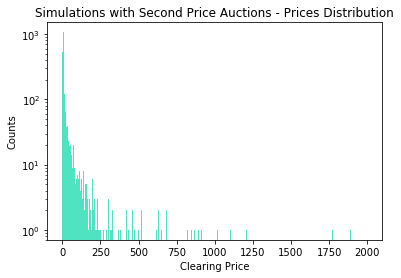

In [15]:
X = list(np.arange(0,2000,5))
plt.hist(price_list,bins=X,range=(min(X),max(X)),label=X,log=True,color='#50E3C2')
plt.title('Simulations with Second Price Auctions - Prices Distribution')
plt.ylabel('Counts')
plt.xlabel('Clearing Price')

plt.show()

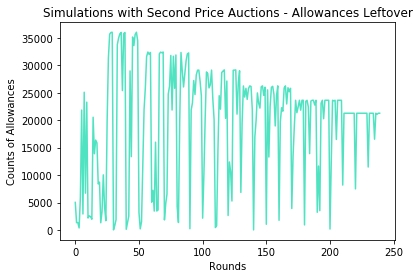

In [13]:
plt.plot(leftover_list,color='#50E3C2')
plt.title('Simulations with Second Price Auctions - Allowances Leftover')
plt.ylabel('Counts of Allowances')
plt.xlabel('Rounds')

plt.show()

The clearing prices of second price auctions, in comparison with that from uniform clearing auctions, are much higher and more spread out. Intuitively, this result is expected because all winners pay a price that is higher than before. From the graph above, we can also conclude that the winning bids have a lot of variations and such characteristic is captured in the second price mechanism.

Interestingly enough, the number of allowances sold and the amount of leftover allowances do not undergo any obvious change after we switch the mechanism.

# Simulations of the Secondary Market (Allowances Transfer between Traders and Companies)


In [22]:
# Average price
average_price = stats.mean(price_list)

# Sum of Traders' Allowances
trader_allowances = traders_allowances
trader_sum = np.sum(trader_allowances)

def companies(i, wealth, req_allowance):
    # Bidding price function 
    if req_allowance <= 0:
        bid = 0
        bid_vol = 0
    elif wealth <= 0:
        bid = 0
        bid_vol = 0
    else:
        value = wealth/req_allowance 
    # To allow for sensible "lowballing" of offers - empirically, there is almost always a bid-ask spread, and we 
    # ensure that happens here
        if value > 0.7*average_price:
            bid = value
        else: 
            bid = average_price   
        bid_vol = int(wealth/bid)
    return i, wealth, bid, bid_vol
    
def traders(i, wealth, trader_allowance):
    # Asking price function
    value = average_price + np.random.normal(0, 3)
    if trader_allowance <= 0:
        offer = 0
        offer_vol = 0
    # To allow for "acceptable loss" trades
    elif value > 0.8*average_price:
        offer = value
    # Traders would be unlikely to offer too low the first time - this sets a "sanity check" floor to constrain the
    # outcome of the noise-trading component of value
    else:
        offer = average_price
    offer_vol = int(trader_allowance)
    return i, wealth, offer, offer_vol

N = 1
for j in range(N):    
        bids = []
        offers = []
        bid_vols = []
        offer_vols = []
        bids_traded = []
        offers_traded = []
        if trader_sum > 0: 
            for i in range(n_companies + n_traders):
                # traders start from index n_companies -1 (e.g. 162 - 1 = 161) since index starts at 0
                if i <= (n_companies - 1): 
                    num, wealth, bid, bid_vol = companies(i, budget[i], req_allowances[i])
                    bids.append(bid)
                    bid_vols.append(bid_vol)
                    
                else: 
                    num, wealth, offer, offer_vol = traders(i, budget[i], trader_allowances[i-n_companies])
                    offers.append(offer)
                    offer_vols.append(offer_vol)
                    
            highest_bidders = np.flip(np.argsort(bids),0) # output bids, descending order
            highest_offers = np.flip(np.argsort(offers),0)

            print("BEFORE counts of companies who meet the required allowances", req_allowances.count(0))
            
            for i in highest_bidders:
                for k in highest_offers:
                    current_bidder = i
                    current_offer = k
                    while bid_vols[current_bidder] > 0:
                        if bids[current_bidder] >= offers[current_offer]:
                            amt = min(bid_vols[current_bidder],offer_vols[current_offer])
                            
                            bid_vols[current_bidder] -= amt
                            offer_vols[current_offer] -= amt
                            budget[current_bidder] -= min(bids[current_bidder],offers[current_offer]) * amt
                            budget[current_offer] += min(bids[current_bidder],offers[current_offer]) * amt
                            req_allowances[current_bidder] -= amt
                        else:
                            break
                    break        
            
        else:
            break 
        print("AFTER counts of companies who meet the required allowances", req_allowances.count(0))


BEFORE counts of companies who meet the required allowances 0
AFTER counts of companies who meet the required allowances 8


We calculate the number of companies who manage to buy all of their required allowances before and after the secondary market and do observe a non-trivial change. Ideally, we can refine our clearing mechanism for the secondary market or repeat the clearing process multiple times until all the allowances in the hand of the traders are sold out in order to improve the results of the secondary market. 

However, we choose to prioritize our time for the primary market (aka. the allowances auction) as that is the major objective for this project.